# Dataset

### Purpose
To have a base format of dataset that can be used for all the model. Utilities can be built based on this format to convert between popular dataset format.

### Structure
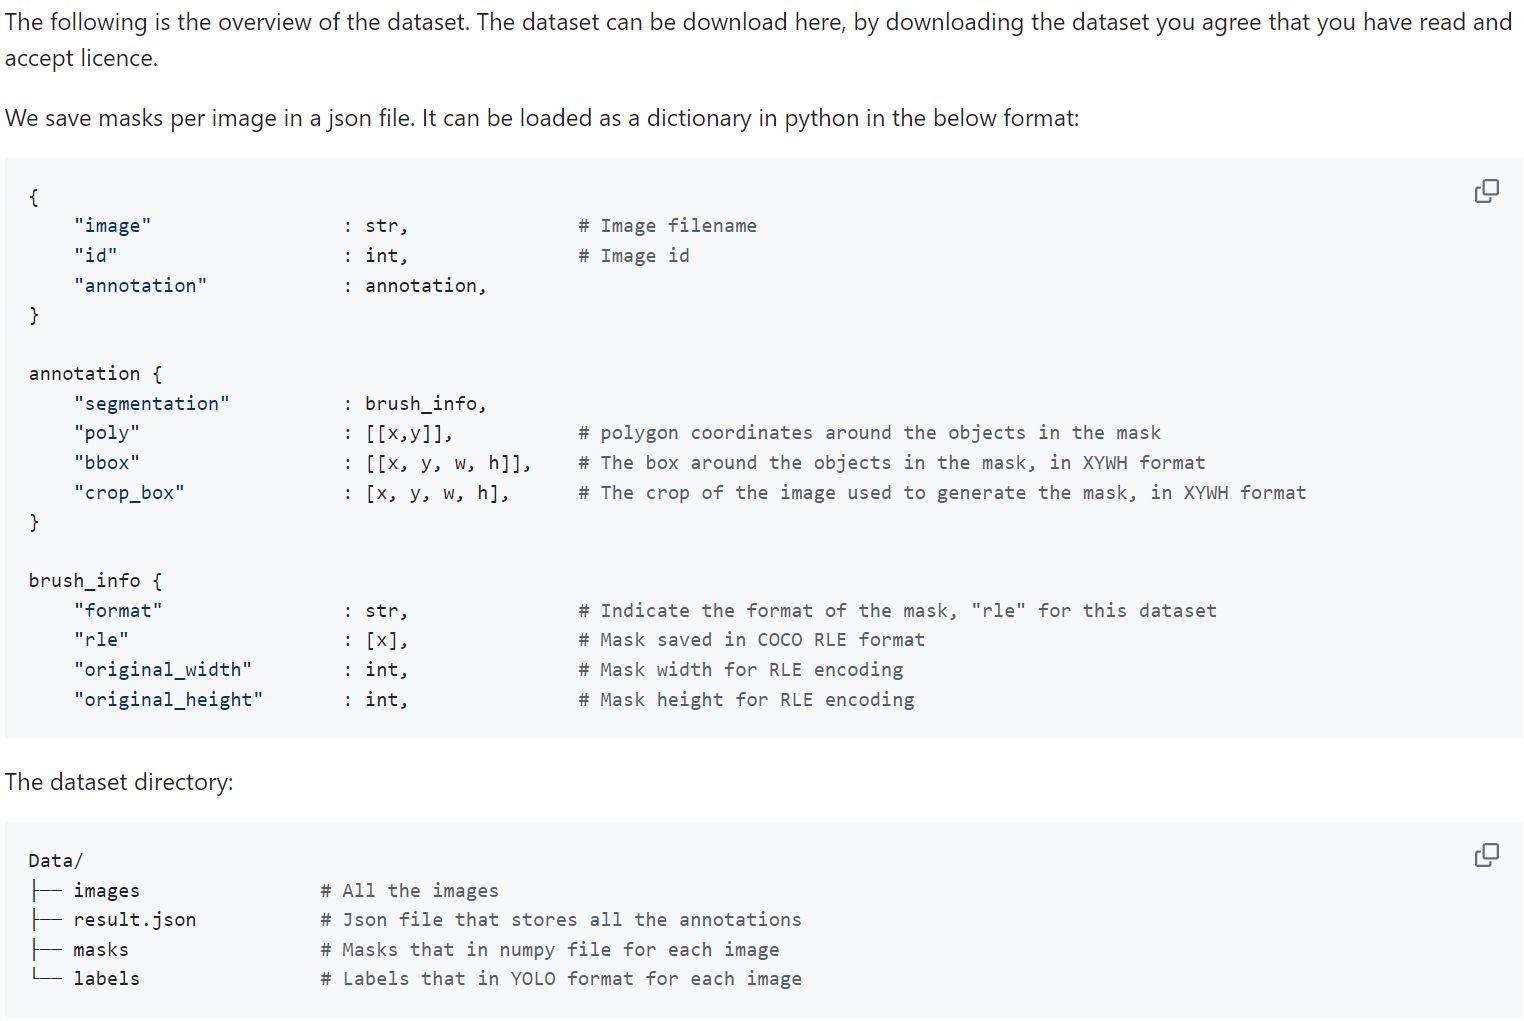
### Problem Statement
- Current data export by seperate label projects, need to merge them into one organized folder.
- Existing datasets have different format, some with mask, some with polygons, some with boxes.


### Generate base format

##### Brush labels
Input: label studio raw json export dataset

Output: binary masks

- append all json files exported from project
- convert json to meet the format
- fill the masks folder
  - each image has one mask
  - mask can seperate each object by id (1, 2, 3, ...)

In [ ]:
import os
import json

out_json = []

# read all json file
for file in os.listdir():
  if file.endswith('.json'):
    # Read JSON file
    with open(file, 'r') as file:
      data = json.load(file)

      # read each annotation in json
      for anno in data:
        obj = {}
        obj['image'] = anno['image'].split('/')[-1].replace("%20", " ")
        obj['id'] = anno['id']

        annotation = {}
        if 'brush' in anno:
          annotation['brush_info'] = anno['brush'][0]
        if 'bbox' in anno:
          annotation['bbox'] = anno['bbox']
        # TODO: polygon info and crop_box

        obj['annotation'] = annotation
        out_json.append(obj)

print(out_json[0])

# Define the path where you want to save the JSON file
json_file_path = '/content/data/result.json'

# Open the file in write mode and use json.dump to write the data
with open(json_file_path, 'w') as json_file:
    json.dump(out_json, json_file, indent=4)


{'image': 'GFP-H2B_A1_1_2023y06m30d_11h02m-10.png', 'id': 58758, 'annotation': {'brush_info': {'format': 'rle', 'rle': [0, 3, 16, 0, 57, 27, 255, 255, 255, 0, 255, 255, 224, 30, 112, 140, 2, 52, 9, 239, 227, 128, 224, 109, 224, 23, 255, 227, 191, 224, 108, 224, 17, 192, 97, 63, 254, 6, 206, 1, 26, 6, 19, 255, 224, 109, 96, 17, 223, 219, 255, 142, 3, 129, 183, 128, 71, 1, 29, 252, 104, 29, 137, 44, 0], 'brushlabels': ['mn_brush'], 'original_width': 224, 'original_height': 224}}}


In [ ]:
import shutil
import os

# Define the path to the directory you want to delete the contents of
folder_path = '/content/images'

# Check if the folder exists
if os.path.exists(folder_path):
    # Delete all contents of the folder
    shutil.rmtree(folder_path)
    print(f'All contents of the folder {folder_path} have been deleted.')
else:
    print(f'The folder {folder_path} does not exist.')


All contents of the folder /content/images have been deleted.


In [ ]:
# copied from label studio github
# https://stackoverflow.com/questions/74339154/how-to-convert-rle-format-of-label-studio-to-black-and-white-image-masks

from typing import List
import numpy as np


class InputStream:
    def __init__(self, data):
        self.data = data
        self.i = 0

    def read(self, size):
        out = self.data[self.i:self.i + size]
        self.i += size
        return int(out, 2)


def access_bit(data, num):
    """ from bytes array to bits by num position"""
    base = int(num // 8)
    shift = 7 - int(num % 8)
    return (data[base] & (1 << shift)) >> shift


def bytes2bit(data):
    """ get bit string from bytes data"""
    return ''.join([str(access_bit(data, i)) for i in range(len(data) * 8)])


def rle_to_mask(rle: List[int], height: int, width: int) -> np.array:
    """
    Converts rle to image mask
    Args:
        rle: your long rle
        height: original_height
        width: original_width

    Returns: np.array
    """

    rle_input = InputStream(bytes2bit(rle))

    num = rle_input.read(32)
    word_size = rle_input.read(5) + 1
    rle_sizes = [rle_input.read(4) + 1 for _ in range(4)]
    print('RLE params:', num, 'values,', word_size, 'word_size,', rle_sizes, 'rle_sizes')

    i = 0
    out = np.zeros(num, dtype=np.uint8)
    while i < num:
        x = rle_input.read(1)
        j = i + 1 + rle_input.read(rle_sizes[rle_input.read(2)])
        if x:
            val = rle_input.read(word_size)
            out[i:j] = val
            i = j
        else:
            while i < j:
                val = rle_input.read(word_size)
                out[i] = val
                i += 1

    image = np.reshape(out, [height, width, 4])[:, :, 3]
    return image

In [ ]:
# save the masks to data/masks/
with open(json_file_path, 'r') as file:
  data = json.load(file)

  for anno in data:
    print(anno['image'])
    print(anno['id'])

    if not anno['annotation'] or 'brush_info' not in anno['annotation']: continue

    brush = anno['annotation']['brush_info']
    rle = brush['rle']
    height = brush['original_height']
    width = brush['original_width']
    mask = rle_to_mask(rle, height, width)
    print(mask.shape)
    print(mask.dtype)

    # Define the path where you want to save the array
    file_path = '/content/data/masks/{}.npy'.format(anno['image'].split('.')[0])

    # Save the array to a .npy file
    np.save(file_path, mask > 0)


GFP-H2B_A1_1_2023y06m30d_11h02m-10.png
58758
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224)
uint8
GFP-H2B_A1_1_2023y06m30d_11h02m-11.png
58759
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224)
uint8
GFP-H2B_A1_1_2023y06m30d_11h02m-12.png
58760
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224)
uint8
GFP-H2B_A1_1_2023y06m30d_11h02m-13.png
58761
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224)
uint8
GFP-H2B_A1_1_2023y06m30d_11h02m-14.png
58762
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224)
uint8
GFP-H2B_A1_1_2023y06m30d_11h02m-15.png
58763
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224)
uint8
GFP-H2B_A1_1_2023y06m30d_12h02m-10.png
58764
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224)
uint8
GFP-H2B_A1_1_2023y06m30d_12h02m-11.png
58765
RLE params: 200704 values, 8 word_size, [3, 4, 8, 16] rle_sizes
(224, 224

Some utils

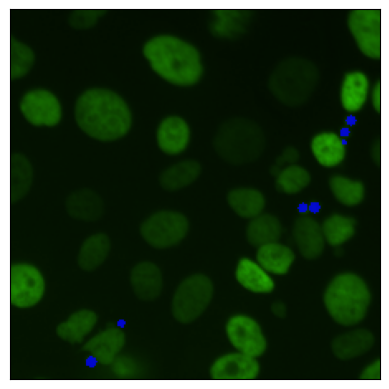

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks
from torchvision.io import read_image

ASSETS_DIRECTORY = "data/images/"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

file_path = '/content/data/masks/10 Gy_GFP-H2B_A1_1_2023y06m24d_20h57m-24.npy'
img = read_image(ASSETS_DIRECTORY + '10 Gy_GFP-H2B_A1_1_2023y06m24d_20h57m-24.png')
mask = torch.from_numpy(np.load(file_path))
drawn_masks = []
drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))
show(drawn_masks)

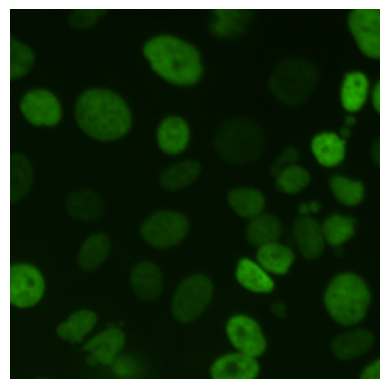

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image_path = ASSETS_DIRECTORY + '10 Gy_GFP-H2B_A1_1_2023y06m24d_20h57m-24.png'
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis labels
plt.show()

In [ ]:
mask.reshape

torch.Size([224, 224])

In [ ]:
from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(mask.reshape((1,224,224)))
print(boxes.size())
print(boxes)

torch.Size([1, 4])
tensor([[ 46.,  64., 209., 216.]])


In [ ]:
import os
import shutil

# Define the paths to the source and destination folders
source_folder = '/content/f3/images'
destination_folder = '/content/data/images'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Move all files from the source folder to the destination folder
for filename in os.listdir(source_folder):
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)
    try:
        shutil.move(source_file, destination_file)
        print(f'Moved {source_file} to {destination_file}')
    except Exception as e:
        print(f'Failed to move {source_file}. Reason: {e}')

print(f'All files moved from {source_folder} to {destination_folder}')


Moved /content/f3/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_17h57m-9.png to /content/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_17h57m-9.png
Moved /content/f3/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_03h57m-14.png to /content/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_03h57m-14.png
Moved /content/f3/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_10h57m-17.png to /content/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_10h57m-17.png
Moved /content/f3/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_01h57m-16.png to /content/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_01h57m-16.png
Moved /content/f3/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_01h57m-18.png to /content/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_01h57m-18.png
Moved /content/f3/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_02h57m-10.png to /content/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_02h57m-10.png
Moved /content/f3/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_08h57m-7.png to /content/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_08h57m-7.png
Moved /content/f3/images/10 Gy_

In [ ]:
mask[mask > 0]

array([ 64,  64, 191, 255, 128,  64, 191, 255, 255, 255, 191,  64, 255,
       255, 255, 255, 255,  64, 191, 255, 255, 255, 128,  64, 191, 255,
       191,  64,  64, 191, 255, 255, 128, 128, 255, 255, 255, 255, 191,
       255, 255, 255, 255,  64, 128, 255, 255, 255, 255,  64, 128, 255,
       255, 128,  64, 128, 255, 255,  64, 128, 255,  64,  64,  64, 191,
       255, 128, 128, 128, 255, 255, 255,  64, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 191, 128, 255, 255, 255, 255, 255,  64,  64,
       255, 255, 255, 255, 255, 128, 255, 255, 255, 255, 255, 128, 191,
       255, 255, 255, 128,  64, 255, 255, 255, 255, 255,  64, 128, 255,
       191, 128, 191, 255, 191,  64,  64,  64, 128, 128, 128, 255, 255,
       255,  64, 128, 255, 255, 255, 128,  64, 255, 255, 255,  64,  64,
        64, 128, 191, 255, 255, 255,  64, 128, 255, 255, 255, 255, 191,
       255, 255, 255, 255, 255, 255,  64, 191, 255, 255, 255, 255, 255,
        64, 255, 255, 255, 255, 128, 128, 191,  64], dtype=uint8

In [ ]:
a = mask > 0
a.shape

(224, 224)

In [ ]:
!unzip /content/project-21-at-2024-07-26-01-11-b3a530a6.zip -d f1
!unzip /content/project-22-at-2024-07-26-01-12-f5e1885b.zip -d f2
!unzip /content/project-26-at-2024-07-26-01-12-2e5e075a.zip -d f3

Archive:  /content/project-21-at-2024-07-26-01-11-b3a530a6.zip
   creating: f1/images/
  inflating: f1/result.json          
  inflating: f1/images/GFP-H2B_A1_1_2023y07m01d_22h02m-20.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y06m30d_17h02m-11.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y06m30d_21h02m-9.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y06m30d_20h02m-11.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m01d_16h02m-12.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y06m30d_12h02m-14.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m01d_06h02m-1.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m03d_00h02m-11.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m01d_02h02m-15.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m02d_23h02m-12.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m02d_23h02m-13.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m01d_02h02m-14.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m03d_00h02m-10.png  
  inflating: f1/images/GFP-H2B_A1_1_2023y07m0

In [ ]:
import numpy as np

# Load the NumPy file (assuming it is a .npy file)
file_path = '/content/1.npy'
data = np.load(file_path)

# Find the elements that are larger than 0
greater_than_zero = data[data > 0]

# Display the filtered elements
print('Elements greater than 0:')
print(greater_than_zero)

from PIL import Image
import numpy as np

# Path to your image file
image_path = '/content/1.png'

# Open the image
image = Image.open(image_path).convert('L')  # 'L' mode is for grayscale

# Convert to a NumPy array
image_array = np.array(image)

print('Image shape:', image_array.shape)
print('Image array:')
print(image_array[image_array > 0])

Elements greater than 0:
[127 191 159  32 223 255 255 255 159  96 255 255 255 255 223 127 255 255
 255 255 255  64 255 255 255 255 255  32 255 255 255 223  96  32  96  64
  32  32 255 255 191  96 127 255 255 255 255  32  32 223 255 255 223  64
 127  32]
Image shape: (224, 224)
Image array:
[127 191 159  32 223 255 255 255 159  96 255 255 255 255 223 127 255 255
 255 255 255  64 255 255 255 255 255  32 255 255 255 223  96  32  96  64
  32  32 255 255 191  96 127 255 255 255 255  32  32 223 255 255 223  64
 127  32]


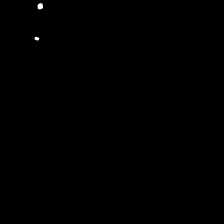

In [ ]:
image

In [ ]:
import os
import shutil

# Define the path to the folder
folder_path = '/content/data/masks'

# Check if the folder exists
if os.path.exists(folder_path):
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Check if it is a file and then remove it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
    print(f'All files in the folder {folder_path} have been deleted.')
else:
    print(f'The folder {folder_path} does not exist.')


All files in the folder /content/data/masks have been deleted.


In [ ]:
 !zip -r data.zip data/

  adding: data/ (stored 0%)
  adding: data/masks/ (stored 0%)
  adding: data/masks/GFP-H2B_A1_1_2023y07m01d_11h02m-0.npy (deflated 100%)
  adding: data/masks/Plate 1_GFP-H2B_D20_1_2022y12m02d_07h30m-29.npy (deflated 100%)
  adding: data/masks/GFP-H2B_A1_1_2023y06m30d_23h02m-11.npy (deflated 100%)
  adding: data/masks/GFP-H2B_A1_1_2023y07m02d_21h02m-13.npy (deflated 100%)
  adding: data/masks/Plate 2_GFP-H2B_E15_1_2022y12m05d_00h00m-6.npy (deflated 100%)
  adding: data/masks/GFP-H2B_A1_1_2023y07m02d_19h02m-15.npy (deflated 100%)
  adding: data/masks/GFP-H2B_A1_1_2023y07m02d_22h02m-11.npy (deflated 100%)
  adding: data/masks/10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-28.npy (deflated 100%)
  adding: data/masks/Plate 1_GFP-H2B_C3_1_2022y12m04d_07h30m-17.npy (deflated 100%)
  adding: data/masks/Plate 1_GFP-H2B_C3_1_2022y12m04d_03h30m-18.npy (deflated 100%)
  adding: data/masks/Plate 1_GFP-H2B_E18_1_2022y12m03d_15h30m-29.npy (deflated 100%)
  adding: data/masks/Plate 1_GFP-H2B_O12_1_2022y12m03d_

##### Polygon labels
Input: polygon labelled data

Output: binary masks

- read polygons per image
- generate binary mask and fill the polygon
- encode mask into rle format
- generate json format for each image


First mount drive and extract dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/PMCC/mnSeg.zip -d data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image


def load_img(img_path):
  """
  Read an image and convert it to RGB format.

  Args:
    img_path (str): Path to the image file.

  Returns:
    Img object: Image object from PIL.
    numpy.ndarray: RGB image array from Image.open.
  """

  img = Image.open(img_path)
  img_arr = np.array(img)
  return img, img_arr

def load_polys(label_path, target_clas = 7, xy_length=(224,224)):
  """
  Read a label txt file and convert it to numpy array.

  Args:
    label_path (str): Path to the label text file.

  Returns:
    numpy.ndarray: polygon array that each polygon contains an array of coordinates ([[x,y],...]).
  """

  poly_arr = []
  with open(label_path, 'r') as label_file:
    # Read and print each line in the file
    for line in label_file:
      l = line.strip().split()
      # class type:
          #   4: cell_active_div, 5: cell_non_div, 6: cell_sick_apop, 7: micronuclei
      cls, points = int(l[0]), l[1:]

      # current focus on mn
      if cls != target_clas:
        continue

      points = np.array(points, dtype=np.float64).reshape((-1, 2))
      points = convert_poly_points(xy_length, points)
      poly_arr.append(points)
  return poly_arr

def convert_poly_points(xy_length, points):
  points = points*xy_length
  points = points.astype(np.int32)
  return points

def change_origin(origin, wnd_size, points):
  """
  Crop an image based on the given points. Change the points relative coordinates regards to the origin.
  yolo format with relative coordinates: (x - origin_x) / 224, (y - origin_y) / 224
  the window size and origin changed.

  Args:
    origin: array of [x,y]
    wnd_size: int or array of [x,y]
  Returns:

  """
  pts = (points - origin) / wnd_size
  return pts

def convert_ROI_dataset(data_dir, dest_dir):
  image_dir = data_dir + 'images/'
  label_dir = data_dir + 'labels/'

  img_cnt = 0
  mn_cnt = 0

  for file in os.listdir(image_dir):
    img_name = file.split('.')[0]

    # read image
    img, img_arr = load_img(image_dir + file)

    # read polygons
    polys = load_polys(label_dir + img_name + '.txt')

    # points to pixel integer
    xy_length = np.array([img_arr.shape[1], img_arr.shape[0]])
    for i,poly in enumerate(polys):
      points = convert_poly_points(xy_length, poly)

      # crop image, save to dest
      x,y = points[0]
      w,h = 112, 112
      img2 = img.crop((x-w,y-h,x+w,y+h))
      img2.save(dest_dir + "images/" + img_name + '_' + str(i) + '.png')
      img_cnt += 1

      # write label
      new_pts = change_origin(np.array([x-w,y-h]), 224, points)
      write_buffer = []
      write_buffer.append("1 " + " ".join(map(str, new_pts.flatten())))

      # check if any other mn in the window
      for j,poly in enumerate(polys):
        if j == i: continue
        pt = poly[0]*xy_length
        if x-w < pt[0] < x+w and y-h < pt[1] < y+h:
          new_pts = change_origin(np.array([x-w,y-h]), 224, poly)
          write_buffer.append("1 " + " ".join(map(str, new_pts.flatten())))

      with open(dest_dir + "labels/" + img_name + '_' + str(i) + '.txt', 'w') as the_file:
        the_file.write("\n".join(write_buffer))
        mn_cnt += len(write_buffer)

  print("image cnt: {}, mn cnt: {}".format(img_cnt, mn_cnt))

def display(img, points):
    cv2.fillPoly(img, pts=[points], color=(255, 0, 255))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img)


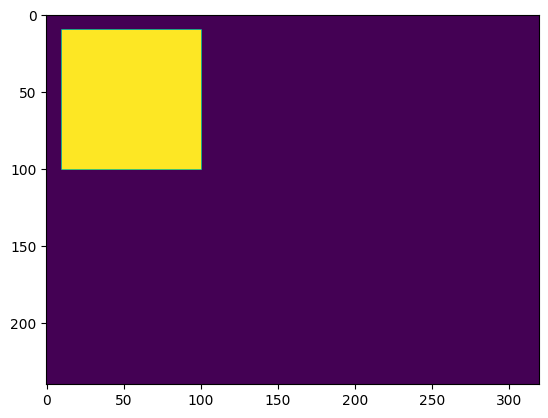

In [ ]:
import cv2
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_path = "/content/data/MNseg/train/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m_0.png"
img = Image.open(img_path)

a3 = np.array( [[[10,10],[100,10],[100,100],[10,100]]], dtype=np.int32 )
im = np.zeros([240,320],dtype=np.uint8)
cv2.fillPoly( im, [a3], 255 )

plt.imshow(im)
plt.show()
# print(np.max(im))
# np.save("d.npy", im)
# x = np.load("d.npy")
# print(x == im)

[array([[0.5       , 0.5       ],
       [0.50446429, 0.50892857],
       [0.50446429, 0.52232143],
       [0.49553571, 0.53125   ],
       [0.48660714, 0.53125   ],
       [0.47767857, 0.52678571],
       [0.47321429, 0.51339286],
       [0.47767857, 0.50892857],
       [0.48214286, 0.5       ],
       [0.49107143, 0.5       ]])]


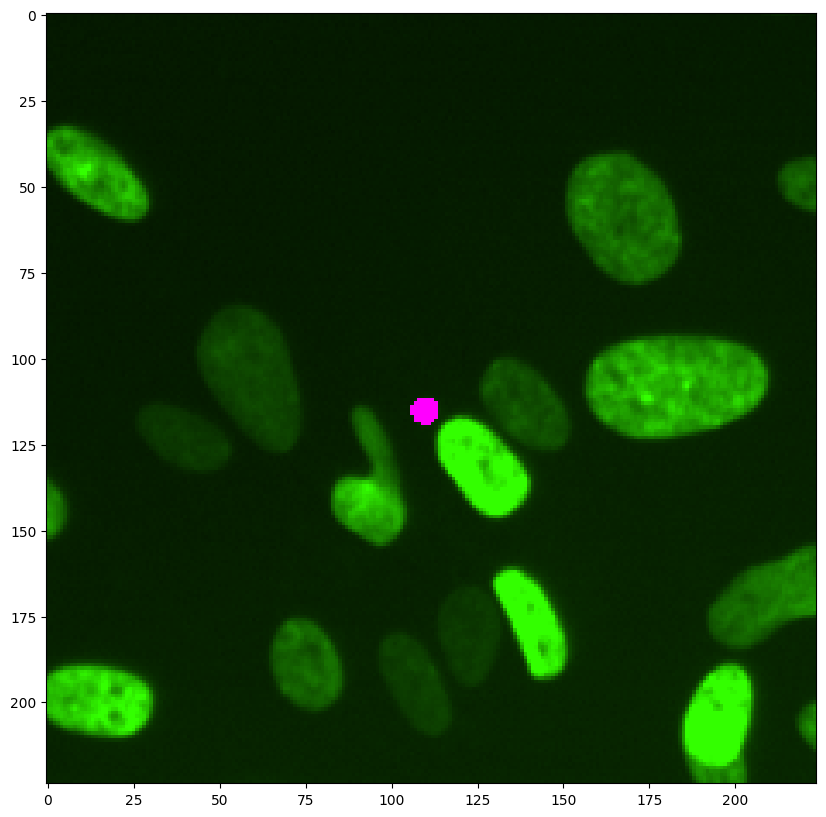

In [ ]:
# Test display one filled polygon on the cropped image
img_path = "/content/data/MNseg/train/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m_0.png"
label_path = "/content/data/MNseg/train/labels/10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m_0.txt"

_, img = load_img(img_path)
points = load_polys(label_path, 1)
print(points)

x,y = img.shape[1], img.shape[0]
xy_length = np.array([img.shape[1], img.shape[0]])
points = points*xy_length
points = points.astype(np.int32)
display(img, points)

In [ ]:
# Extract all files from MNseg and output to data/MNmask2/masks
import shutil
import os

source_folder = '/content/data/MNseg/val/labels/'
destination_folder = '/content/data/MNmask2/masks/'

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Copy all files from source to destination
for filename in os.listdir(source_folder):
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename.split('.')[0] + '.npy')

    # read relative position poly points from text file
    points = load_polys(source_file, 1)
    # print(points)

    im = np.zeros([224,224],dtype=np.uint8)
    cv2.fillPoly( im, points, 255 )
    np.save(destination_file, im)

In [ ]:
img_folder = '/content/data/MNmask2/images/'
print(len(os.listdir(img_folder)))
print(len(os.listdir(destination_folder)))

442
442


Get dataset from drive

In [ ]:
# copy all images to new mask dataset
# !cp -r /content/data/MNseg/train/images/* /content/data/MNmask2/images/
# !cp -r /content/data/MNseg/val/images/* /content/data/MNmask2/images/
!cp /content/drive/MyDrive/PMCC/mnMask.zip /content/

In [ ]:
! unzip mnMask.zip

Archive:  mnMask.zip
   creating: mnMask/data/
   creating: mnMask/data/.ipynb_checkpoints/
   creating: mnMask/data/images/
   creating: mnMask/data/masks/
  inflating: mnMask/data/result.json  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-10.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-11.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-12.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-13.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-14.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-15.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-26.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-22.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-23.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_18h57m-19.png  
 extracting: m

### Convert base format

##### Extract boxes and each mask from comprehensive mask.

Use cv2 [connectedComponents](https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/)

In [ ]:
import numpy as np
import cv2
import torch

def seperate_semantic_mask(mask):
  '''
  Convert mask that contains all obj into individual mask that
    contain each obj, from semantic seg to instance seg.

  Args:
    im: mask from the dataset

  Returns:
    [im]: list of masks
  '''

  # Convet the mask into binary
  binary_mask = (mask > 0).astype(np.uint8)

  # Find the connected components in the image
  num_labels, labels_im = cv2.connectedComponents(binary_mask)

  # Map component labels to individual masks
  individual_masks = []
  for label in range(1, num_labels):  # Start from 1 to skip the background
    individual_mask = (labels_im == label).astype(np.uint8)
    if individual_mask.sum() < 5: continue
    individual_masks.append(torch.from_numpy(individual_mask))

  # Return the list of individual masks
  return individual_masks

##### Convert binary mask to yolo detection dataset (bounding box)

In [ ]:
from torchvision.ops.boxes import masks_to_boxes

def convert_to_boxes(mask):
  # split the color-encoded mask into a set
  # of binary masks
  masks = seperate_semantic_mask(mask)
  masks = torch.stack(masks)

  num_objs = len(masks)

  # get bounding box coordinates for each mask
  boxes = masks_to_boxes(masks)

  return boxes

In [ ]:
def to_yolo_box(boxes):
  l = []
  for box in boxes:
    w,h = box[2] - box[0], box[3] - box[1]
    x,y = box[0] + w/2, box[1] + h/2
    w,h = w/224, h/224
    x,y = x/224, y/224
    # Convert each tensor in the list to a float
    float_list = [str(tensor.item()) for tensor in [x,y,w,h]]
    l.append(float_list)
  return l

In [ ]:
import os
from PIL import Image

path = "mnDetect"
root = "mnMask/data"
imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

cnt = 0
total = len(masks)
for mask in masks:
  file_name = mask.split(".")[0]
  mask_name = file_name + ".npy"
  img_name = file_name + ".png"
  mask_path = os.path.join(root, "masks", mask_name)
  image_path = os.path.join(root, "images", img_name)

  mask = np.load(mask_path)
  masks = seperate_semantic_mask(mask)
  masks = torch.stack(masks)

  boxes = masks_to_boxes(masks)
  for box in boxes:
    if box[0] == box[2] or box[1] == box[3]:
      box[2] += 1
      box[3] += 1

  boxes = to_yolo_box(boxes)

  # write to file
  if total - cnt <= 50:
    img_path = "mnDetect/images/val"
    label_path = "mnDetect/labels/val"
  else:
    img_path = "mnDetect/images/train"
    label_path = "mnDetect/labels/train"

  image = Image.open(image_path)

  # Save the image to the folder with a new name
  save_path = os.path.join(img_path, img_name)
  image.save(save_path)

  # Write labels to text file
  with open(os.path.join(label_path, mask_name.split('.')[0] + ".txt"), 'w') as f:
    for box in boxes:
      print(box)
      f.writelines("0 " + " ".join(box) + "\n")
  cnt += 1
  print(cnt, "/", total)
  # break


FileNotFoundError: [Errno 2] No such file or directory: 'mnDetect/images/train/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-26.png'

In [ ]:
imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

cnt = 0
total = len(imgs)
print(total, len(masks))

967 924


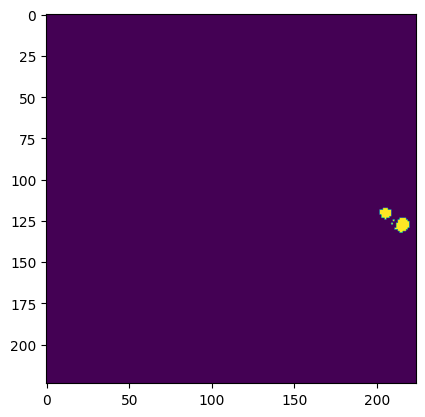

In [ ]:
from torchvision.io import read_image
import os
import numpy as np
import matplotlib.pyplot as plt
# /content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_02h57m-13.png
# /content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_19h57m-10.png
# /content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_05h57m-13.png
# 10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-26
img_path = os.path.join("/content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-26.png")
mask_path = os.path.join("/content/mnMask/data/masks/10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-26.npy")
img = read_image(img_path)
mask = np.load(mask_path)
plt.imshow(mask)

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


ASSETS_DIRECTORY = "../assets"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.Size([4, 4])
tensor([[202., 118., 208., 124.],
        [210., 125., 210., 125.],
        [211., 124., 219., 132.],
        [209., 127., 209., 127.]])


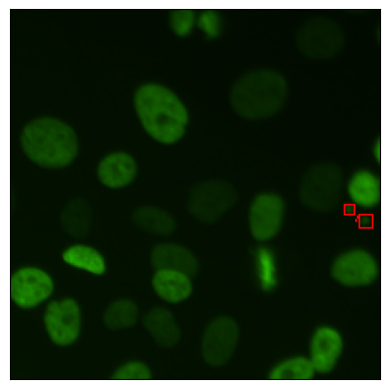

In [ ]:
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes

mask = np.load(mask_path)
masks = seperate_semantic_mask(mask)
masks = torch.stack(masks)
boxes = masks_to_boxes(masks)
print(boxes.size())
print(boxes)

drawn_boxes = draw_bounding_boxes(img, boxes, colors="red")
show(drawn_boxes)

In [ ]:
!zip -r mnDetect.zip mnDetect/

  adding: mnDetect/ (stored 0%)
  adding: mnDetect/.ipynb_checkpoints/ (stored 0%)
  adding: mnDetect/labels/ (stored 0%)
  adding: mnDetect/labels/.ipynb_checkpoints/ (stored 0%)
  adding: mnDetect/labels/val/ (stored 0%)
  adding: mnDetect/labels/val/Plate 1_GFP-H2B_M4_1_2022y12m02d_11h30m-14.txt (deflated 60%)
  adding: mnDetect/labels/val/.ipynb_checkpoints/ (stored 0%)
  adding: mnDetect/labels/val/Plate 2_GFP-H2B_J2_1_2022y12m04d_04h00m-4.txt (deflated 44%)
  adding: mnDetect/labels/val/Plate 1_GFP-H2B_N2_1_2022y12m02d_23h30m-9.txt (deflated 47%)
  adding: mnDetect/labels/val/Plate 2_GFP-H2B_J2_1_2022y12m04d_04h00m-8.txt (deflated 36%)
  adding: mnDetect/labels/val/Plate 1_GFP-H2B_O12_1_2022y12m03d_19h30m-27.txt (deflated 58%)
  adding: mnDetect/labels/val/Plate 1_GFP-H2B_N7_1_2022y12m02d_15h30m-14.txt (deflated 62%)
  adding: mnDetect/labels/val/Plate 1_GFP-H2B_M4_1_2022y12m02d_11h30m-15.txt (deflated 67%)
  adding: mnDetect/labels/val/Plate 1_GFP-H2B_N2_1_2022y12m02d_23h30m-11.

In [ ]:
!cp mnDetect.zip /content/drive/MyDrive/PMCC/

#### Label instance in masks

In [ ]:
!cp /content/drive/MyDrive/PMCC/mnMask.zip /content/
! unzip mnMask.zip

Archive:  mnMask.zip
   creating: mnMask/data/
   creating: mnMask/data/.ipynb_checkpoints/
   creating: mnMask/data/images/
   creating: mnMask/data/masks/
  inflating: mnMask/data/result.json  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-10.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-11.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-12.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-13.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-14.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-15.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_16h57m-26.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-22.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_17h57m-23.png  
 extracting: mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m23d_18h57m-19.png  
 extracting: m

In [ ]:
import numpy as np
import cv2
import torch

def label_semantic_mask(mask):
  '''
  Convert mask that contains all obj into individual mask that
    contain each obj, from semantic seg to instance seg.

  Args:
    im: mask from the dataset

  Returns:
    mask: mask with each instance labeled from 1 to n
  '''

  # Convet the mask into binary
  binary_mask = (mask > 0).astype(np.uint8)

  # Find the connected components in the image
  num_labels, labels_im = cv2.connectedComponents(binary_mask)

  # Map component labels to individual masks
  individual_masks = np.zeros((224,224))
  for label in range(1, num_labels):  # Start from 1 to skip the background
    individual_mask = (labels_im == label).astype(np.uint8)
    if individual_mask.sum() < 5: continue
    individual_masks[individual_mask>0] = label

  # Return the list of individual masks
  return individual_masks

In [ ]:
import os
from PIL import Image

path = "mnMask"
root = "mnMask/data"
imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

cnt = 0
total = len(masks)
for mask in masks:
  file_name = mask.split(".")[0]
  mask_name = file_name + ".npy"
  img_name = file_name + ".png"
  mask_path = os.path.join(root, "masks", mask_name)
  image_path = os.path.join(root, "images", img_name)

  mask = np.load(mask_path)
  masks = label_semantic_mask(mask)

  # Define the path where you want to save the array
  file_path = '/content/mnMask/data/label_masks/{}.npy'.format(file_name)

  # Save the array to a .npy file
  np.save(file_path, masks)

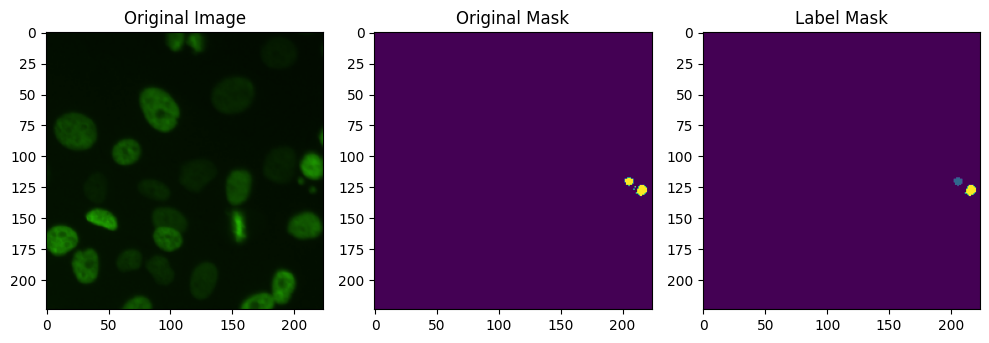

In [ ]:
from torchvision.io import read_image
import os
import numpy as np
import matplotlib.pyplot as plt
# /content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_02h57m-13.png
# /content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_19h57m-10.png
# /content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_05h57m-13.png
# 10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-26
img_path = os.path.join("/content/mnMask/data/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-26.png")
label_mask_path = os.path.join("/content/mnMask/data/label_masks/10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-26.npy")
mask_path = os.path.join("/content/mnMask/data/masks/10 Gy_GFP-H2B_A1_1_2023y06m24d_15h57m-26.npy")
img = read_image(img_path)
mask = np.load(mask_path)
label_path = np.load(label_mask_path)

# Create a figure and arrange subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plotting on each subplot
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title('Original Image')

axes[1].imshow(mask)
axes[1].set_title('Original Mask')

axes[2].imshow(label_path)
axes[2].set_title('Label Mask')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
!zip -r mnMaskLabel.zip mnMask/
!cp mnMaskLabel.zip /content/drive/MyDrive/PMCC/

  adding: mnMask/ (stored 0%)
  adding: mnMask/data/ (stored 0%)
  adding: mnMask/data/.ipynb_checkpoints/ (stored 0%)
  adding: mnMask/data/label_masks/ (stored 0%)
  adding: mnMask/data/label_masks/GFP-H2B_A1_1_2023y06m30d_12h02m-12.npy (deflated 100%)
  adding: mnMask/data/label_masks/Plate 1_GFP-H2B_G20_1_2022y12m01d_23h30m-25.npy (deflated 100%)
  adding: mnMask/data/label_masks/GFP-H2B_A1_1_2023y07m03d_07h02m-9.npy (deflated 100%)
  adding: mnMask/data/label_masks/Plate 1_GFP-H2B_E12_1_2022y12m05d_11h30m-3.npy (deflated 100%)
  adding: mnMask/data/label_masks/Plate 1_GFP-H2B_E5_1_2022y12m03d_23h30m-24.npy (deflated 100%)
  adding: mnMask/data/label_masks/10 Gy_GFP-H2B_B1_2_2023y06m26d_14h17m_0.npy (deflated 100%)
  adding: mnMask/data/label_masks/10 Gy_GFP-H2B_A1_1_2023y06m26d_01h17m_0.npy (deflated 100%)
  adding: mnMask/data/label_masks/Plate 1_GFP-H2B_D16_1_2022y12m05d_15h30m-6.npy (deflated 100%)
  adding: mnMask/data/label_masks/10 Gy_GFP-H2B_A1_3_2023y06m24d_21h17m_2.npy (d

### Include condition folder

In [ ]:
def get_folder_name(s):
  return s.split("/")[-2]

def get_file_name(s):
  return s.split("/")[-1].replace("%20", " ")

In [ ]:
import json

data = []

f = open('project-21-at-2024-08-22-16-23-77c8b253.json')
data1 = json.load(f)
data.append(data1)

f = open('project-22-at-2024-08-22-15-53-af12992b.json')
data2 = json.load(f)
data.append(data2)

f = open('project-26-at-2024-08-22-16-24-39ddab9d.json')
data3 = json.load(f)
data.append(data3)

map = {}
for d in data:
  for i in range(len(d)):
    map[get_file_name(d[i]['data']['image'])] = get_folder_name(d[i]['data']['image'])

with open('condition_map.json', 'w') as f:
  json.dump(map, f)

In [ ]:
map = json.load(open("condition_map.json"))
s = set()
cnt = 0
for k,v in map.items():
  s.add(v)
  cnt += 1
print(s, cnt)

{'new_RPE-1-2', 'sythego_rep3_cropped', 'MCF10A_cropped'} 1019
